#  Predicting Final Race Position with Feature-Engineered Data

In [1]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/features/driver_features_2018_2024.csv')

# Drop the columns
df_clean = df.drop(columns=['NumPitstops', 'PitStopLaps', 'PitCompounds', 'AvgPitStopDuration'])

# Save the cleaned version (optional)
df_clean.to_csv('../data/features/driver_features_2018_2024_cleaned.csv', index=False)

print(df_clean.shape)

(3033, 11)


In [3]:
df_clean.head()

,Season,Race,Driver,Team,Grid,Position,MeanLapTime,AirTemp,TrackTemp,Humidity,Rainfall
0,2018,Australian Grand Prix,GAS,Toro Rosso,20.0,18.0,0 days 00:01:33.188538461,24.077477,36.324324,30.915315,True
1,2018,Australian Grand Prix,PER,Force India,12.0,11.0,0 days 00:01:33.450000,24.077477,36.324324,30.915315,True
2,2018,Australian Grand Prix,ALO,McLaren,10.0,5.0,0 days 00:01:33.123603448,24.077477,36.324324,30.915315,True
3,2018,Australian Grand Prix,LEC,Sauber,18.0,13.0,0 days 00:01:33.949000,24.077477,36.324324,30.915315,True
4,2018,Australian Grand Prix,STR,Williams,13.0,14.0,0 days 00:01:33.992603448,24.077477,36.324324,30.915315,True


In [4]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033 entries, 0 to 3032
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Season       3033 non-null   int64  
 1   Race         3033 non-null   object 
 2   Driver       3033 non-null   object 
 3   Team         3033 non-null   object 
 4   Grid         3033 non-null   float64
 5   Position     3033 non-null   float64
 6   MeanLapTime  2964 non-null   object 
 7   AirTemp      3033 non-null   float64
 8   TrackTemp    3033 non-null   float64
 9   Humidity     3033 non-null   float64
 10  Rainfall     3033 non-null   bool   
dtypes: bool(1), float64(5), int64(1), object(4)
memory usage: 240.0+ KB


In [5]:
df_clean.describe()

,Season,Grid,Position,AirTemp,TrackTemp,Humidity
count,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000
mean,2021.061985,10.221893,10.479064,23.638447,35.870713,53.154695
std,1.989447,5.803899,5.757263,4.893893,9.002281,16.228570
min,2018.000000,0.000000,1.000000,9.500000,15.205755,7.109756
25%,2019.000000,5.000000,5.000000,20.460109,29.945455,40.519231
50%,2021.000000,10.000000,10.000000,23.203030,35.752903,54.108228
75%,2023.000000,15.000000,15.000000,27.431677,42.070253,62.335616
max,2024.000000,20.000000,20.000000,36.565854,54.525620,96.435862


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

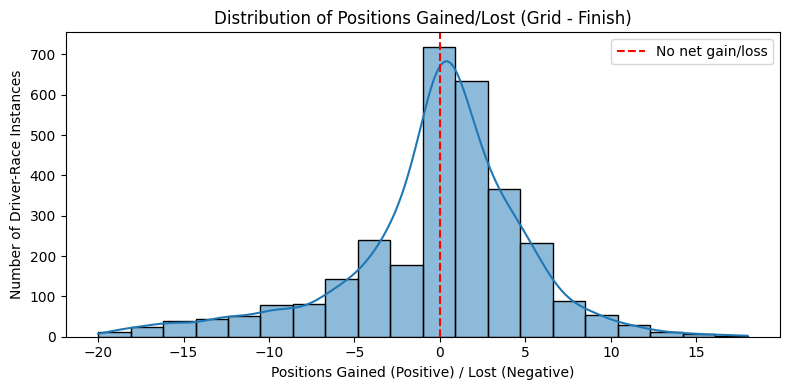

In [7]:
# Compute position delta (positions gained/lost)
# Make sure both 'Grid' and 'Position' are numeric

# Remove pre-season testing (not real races)
df_clean = df_clean[~df_clean['Race'].str.contains('Testing')]

df_clean['Grid'] = pd.to_numeric(df_clean['Grid'], errors='coerce')
df_clean['Position'] = pd.to_numeric(df_clean['Position'], errors='coerce')
df_clean['PositionDelta'] = df_clean['Grid'] - df_clean['Position']

# Plot distribution of position delta
plt.figure(figsize=(8,4))
sns.histplot(df_clean['PositionDelta'].dropna(), bins=20, kde=True)
plt.title('Distribution of Positions Gained/Lost (Grid - Finish)')
plt.xlabel('Positions Gained (Positive) / Lost (Negative)')
plt.ylabel('Number of Driver-Race Instances')
plt.axvline(0, color='red', linestyle='--', label='No net gain/loss')
plt.legend()
plt.tight_layout()
plt.show()

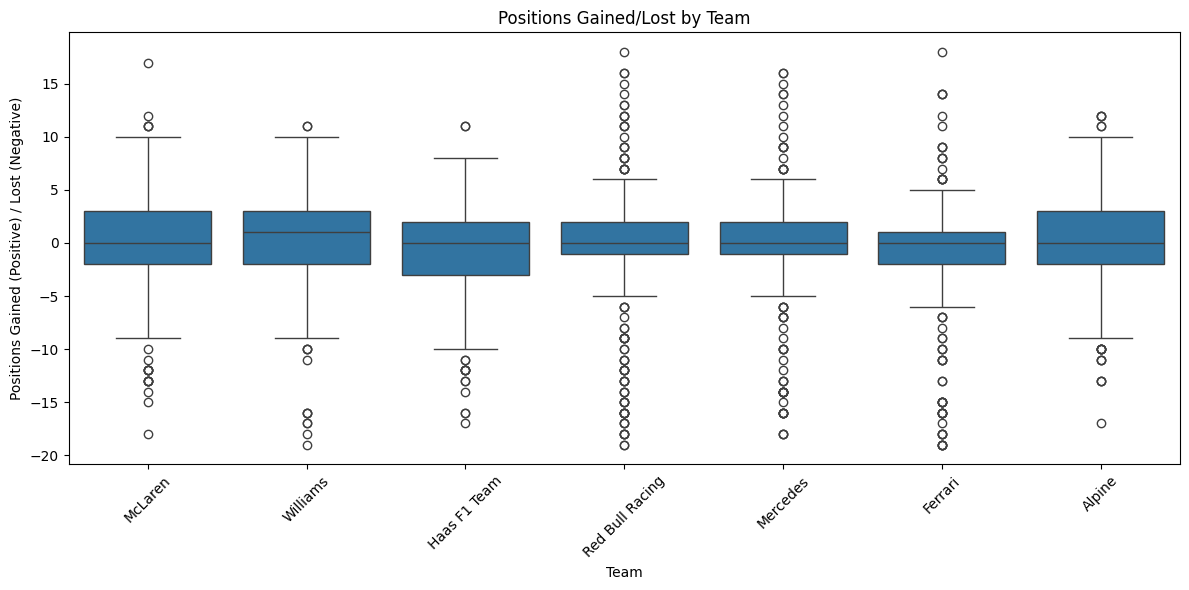

In [8]:
# Optional: Boxplot by team (if sample size per team is large enough)
plt.figure(figsize=(12,6))
# Use the top 7 teams by appearances for clarity, else use all
top_teams = df_clean['Team'].value_counts().nlargest(7).index.tolist()
sns.boxplot(x='Team', y='PositionDelta', data=df_clean[df_clean['Team'].isin(top_teams)])
plt.title('Positions Gained/Lost by Team')
plt.ylabel('Positions Gained (Positive) / Lost (Negative)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
def to_seconds(x):
    if pd.isnull(x):
        return None
    if isinstance(x, (int, float)):
        return x
    # Convert pandas Timedelta or string to total seconds
    try:
        return pd.to_timedealta(x).total_seconds()
    except Exception:
        return None

df_clean['MeanLapTime_sec'] = df_clean['MeanLapTime'].apply(to_seconds)        

In [10]:
from sklearn.model_selection import train_test_split

# features to use
features = ['Grid', 'MeanLapTime_sec', 'AirTemp', 'TrackTemp', 'Humidity', 'Rainfall', 'Team']
# Drop rows with excessive missingness in critical fields (simple version)
ml_df = df_clean.dropna(subset=['Position', 'Grid', 'Team', 'MeanLapTime'])

X = ml_df[features]
y = ml_df['Position']

# One-hot encode team names (convert to columns of 0s and 1s)
X = pd.get_dummies(X, columns=['Team'], dummy_na=True)
if 'Rainfall' in X:
    X['Rainfall'] = X['Rainfall'].astype(int)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error: 3.32
R^2 Score: 0.423


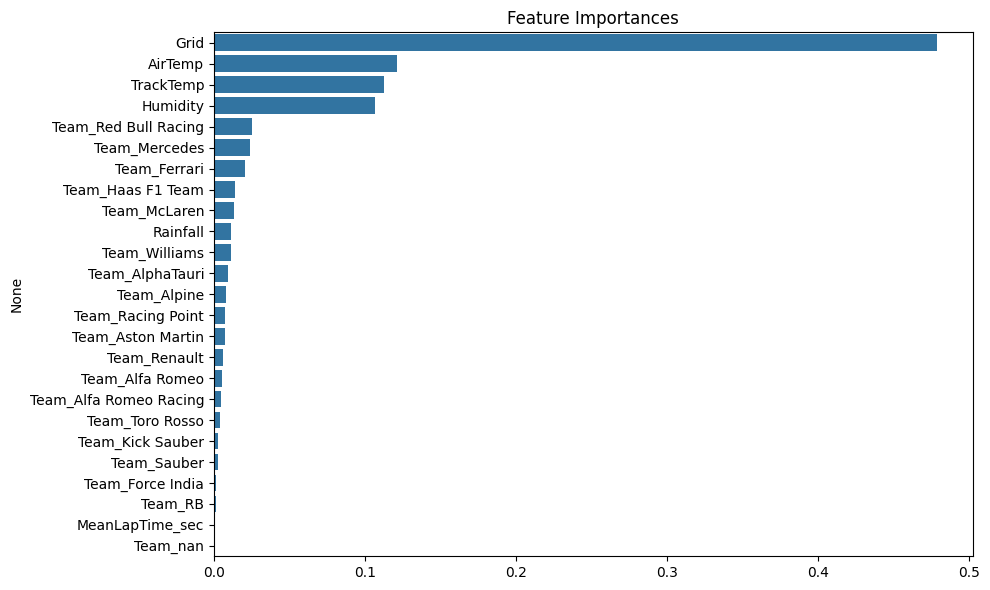

In [14]:
importances = model.feature_importances_
features_list = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
sns.barplot(x=importances[indices], y=features_list[indices])
plt.tight_layout()
plt.show()

In [15]:
X_train.to_csv('../data/features/X_train.csv', index=False)
X_test.to_csv('../data/features/X_test.csv', index=False)
y_train.to_csv('../data/features/y_train.csv', index=False)
y_test.to_csv('../data/features/y_test.csv', index=False)

In [16]:
import joblib

joblib.dump(model, '../models/random_forest_f1.pkl')

['../models/random_forest_f1.pkl']

## Model Results Summary

- **Features used**: Grid, Mean Lap Time, Weather variables, Team (one-hot encoded)
- **Mean Absolute Error (MAE)**: 3.32  
- **R² Score**: 0.423  

This means the model predicts finishing position within ~3 grid places on average. The features explain about 42% of all variation in finishing order.
Pit stop features are missing in this dataset due to current F1 open-data API limitations.


### Limitations
- Pit stop data was unavailable due to current API issues
- Model does not account for DNFs, red flags, or race-day incidents 
- Performance is competitive for open-data F1, but not perfect due to feature limits


In [17]:
result_summary = pd.DataFrame({
    'Metric': ['Mean Absolute Error', 'R2 Score'],
    'Value': [mae, r2]
})
result_summary.to_csv('../results/model_results_summary.csv', index=False)
print(result_summary)

                Metric     Value
0  Mean Absolute Error  3.324927
1             R2 Score  0.422568


In [18]:
# Calculate MAE if you just predicted everyone would finish where they started
naive_mae = (ml_df['Grid'] - ml_df['Position']).abs().mean()
print(f"Naive MAE (predict grid as finish): {naive_mae:.2f}")

Naive MAE (predict grid as finish): 3.58


In [19]:
result_summary.loc[len(result_summary)] = ['Naive Baseline MAE', naive_mae]
result_summary.to_csv('../results/model_results_summary.csv', index=False)
print(result_summary)

                Metric     Value
0  Mean Absolute Error  3.324927
1             R2 Score  0.422568
2   Naive Baseline MAE  3.579285


## Interpretation

The model improves over the naive baseline, reducing average prediction error below simply using grid order. Most prediction errors arise from factors outside available features (random events, pit stops, DNFs, etc.), which is expected in public F1 data.


### Feature Importance

Top predictors, by model weight:
- Starting grid position
- Air Temperature
- Track Temperature
- Humidity

# F1 Finishing Position Prediction Project

### Project Overview
Predicts race finishing position in F1 using open multi-season driver-race data (2018–2024). Data includes grid slot, average lap time, team, and weather. Features engineered and analyzed using pandas and scikit-learn.

### Main Results
- Model: Random Forest Regressor
- MAE: 3.32 (average finish position error)
- R²: 0.42

### Limitations
- Pit stop and some stint details unavailable (API constraint)
- Does not predict DNF/retirement

### Files
- `driver_features_2018_2024.csv` – main data
- `notebooks/f1_prediction.ipynb` – code/analysis
- `results/model_results_summary.csv` – results table


In [20]:
import ssl
print(ssl.OPENSSL_VERSION)

OpenSSL 3.5.1 1 Jul 2025


In [21]:
laps_df = pd.read_csv('../data/features/lap_level_data_2018_2024.csv')
laps_df.head()

/var/folders/mt/xrr07_4s60g1zswr8f0cq20r0000gn/T/ipykernel_4943/1097642299.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  laps_df = pd.read_csv('../data/features/lap_level_data_2018_2024.csv')


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Season,Race
0,0 days 00:08:53.226000,GAS,10,0 days 00:01:45.060000,1.0,NaN,NaN,NaN,NaN,0 days 00:00:25.495000,...,0 days 00:07:07.988000,2018-03-25 05:13:19.169,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
1,0 days 00:10:26.598000,GAS,10,0 days 00:01:33.372000,2.0,1.0,NaN,NaN,0 days 00:00:31.357000,0 days 00:00:24.825000,...,0 days 00:08:53.226000,2018-03-25 05:15:04.407,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
2,0 days 00:11:59.459000,GAS,10,0 days 00:01:32.861000,3.0,1.0,NaN,NaN,0 days 00:00:31.160000,0 days 00:00:24.725000,...,0 days 00:10:26.598000,2018-03-25 05:16:37.779,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
3,0 days 00:13:31.643000,GAS,10,0 days 00:01:32.184000,4.0,1.0,NaN,NaN,0 days 00:00:30.835000,0 days 00:00:24.730000,...,0 days 00:11:59.459000,2018-03-25 05:18:10.640,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
4,0 days 00:15:03.975000,GAS,10,0 days 00:01:32.332000,5.0,1.0,NaN,NaN,0 days 00:00:30.716000,0 days 00:00:24.821000,...,0 days 00:13:31.643000,2018-03-25 05:19:42.824,21.0,17.0,False,NaN,False,True,2018,Australian Grand Prix


In [22]:
# Convert 'LapNumber' and 'Stint' to integers (optional, good practice)
laps_df['LapNumber'] = laps_df['LapNumber'].astype(int)
laps_df['Stint'] = laps_df['Stint'].astype(pd.Int64Dtype())  # Handles NaN safely

# Group by season, race, driver
grouped = laps_df.groupby(['Season', 'Race', 'Driver'])

# Container for new features
stint_features = []

for (season, race, driver), group in grouped:
    stints = group['Stint'].dropna().unique()
    num_stints = len(stints)
    stint_lengths = group.groupby('Stint')['LapNumber'].count()
    # Safe: If NaN in 'Stint', stint_lengths will ignore it

    features = {
        'Season': season,
        'Race': race,
        'Driver': driver,
        'NumStints': num_stints,
        'EstimatedPitStops': max(num_stints - 1, 0),
        'AvgStintLength': stint_lengths.mean() if not stint_lengths.empty else None,
        'MinStintLength': stint_lengths.min() if not stint_lengths.empty else None,
        'MaxStintLength': stint_lengths.max() if not stint_lengths.empty else None,
    }
    stint_features.append(features)

# Create DataFrame
stint_df = pd.DataFrame(stint_features)

# Inspect
print(stint_df.head())

   Season                  Race Driver  NumStints  EstimatedPitStops  \
0    2018  Abu Dhabi Grand Prix    ALO          2                  1   
1    2018  Abu Dhabi Grand Prix    BOT          3                  2   
2    2018  Abu Dhabi Grand Prix    ERI          1                  0   
3    2018  Abu Dhabi Grand Prix    GAS          2                  1   
4    2018  Abu Dhabi Grand Prix    GRO          2                  1   

   AvgStintLength  MinStintLength  MaxStintLength  
0       27.000000            27.0            27.0  
1       18.333333            15.0            24.0  
2       25.000000            25.0            25.0  
3       23.500000            18.0            29.0  
4       27.000000             7.0            47.0  


In [23]:
full_df = pd.merge(df_clean, stint_df, on=['Season', 'Race', 'Driver'], how='left')
print(full_df.head())


   Season                   Race Driver         Team  Grid  Position  \
0    2018  Australian Grand Prix    GAS   Toro Rosso  20.0      18.0   
1    2018  Australian Grand Prix    PER  Force India  12.0      11.0   
2    2018  Australian Grand Prix    ALO      McLaren  10.0       5.0   
3    2018  Australian Grand Prix    LEC       Sauber  18.0      13.0   
4    2018  Australian Grand Prix    STR     Williams  13.0      14.0   

                 MeanLapTime    AirTemp  TrackTemp   Humidity  Rainfall  \
0  0 days 00:01:33.188538461  24.077477  36.324324  30.915315      True   
1     0 days 00:01:33.450000  24.077477  36.324324  30.915315      True   
2  0 days 00:01:33.123603448  24.077477  36.324324  30.915315      True   
3     0 days 00:01:33.949000  24.077477  36.324324  30.915315      True   
4  0 days 00:01:33.992603448  24.077477  36.324324  30.915315      True   

   PositionDelta MeanLapTime_sec  NumStints  EstimatedPitStops  \
0            2.0            None          1       

In [24]:
full_df['MeanLapTime_sec'] = pd.to_timedelta(full_df['MeanLapTime']).dt.total_seconds()

In [25]:
features = [
    'Grid', 'MeanLapTime_sec', 'AirTemp', 'TrackTemp', 'Humidity', 'Rainfall', 'Team',
    'NumStints', 'EstimatedPitStops', 'AvgStintLength', 'MinStintLength', 'MaxStintLength'
]

ml_df = full_df.dropna(subset=['Position', 'Grid', 'Team', 'MeanLapTime_sec'])
X = ml_df[features]
y = ml_df['Position']

# One-hot encode team
X = pd.get_dummies(X, columns=['Team'], dummy_na=False)
X['Rainfall'] = X['Rainfall'].astype(int)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.3f}")

Mean Absolute Error: 2.57
R² Score: 0.647


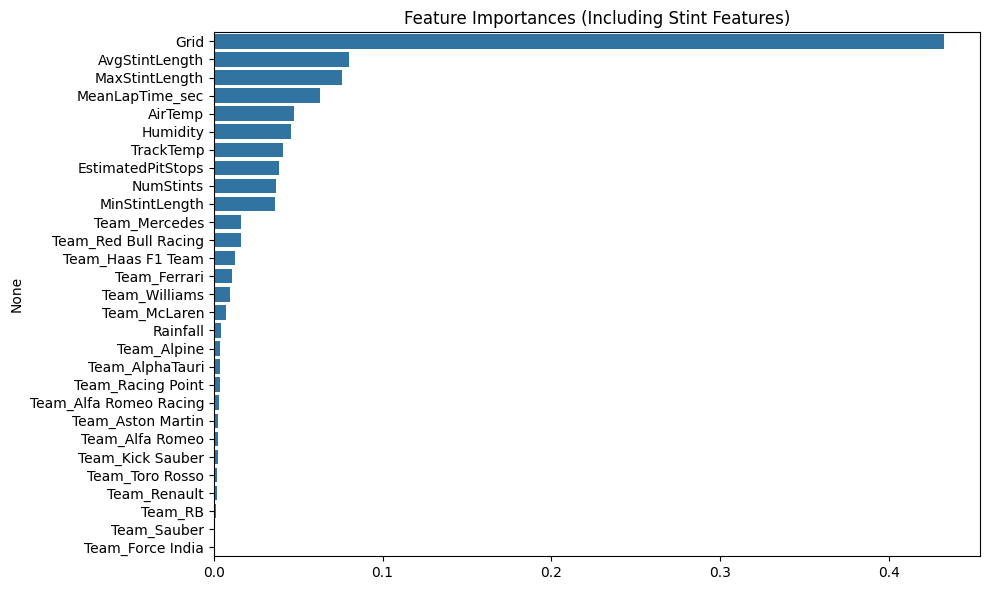

In [27]:
importances = model.feature_importances_
features_list = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features_list[indices])
plt.title("Feature Importances (Including Stint Features)")
plt.tight_layout()
plt.show()

## 🚀 F1 Model Enhancement: Stint Feature Engineering

Our race finishing position prediction model was enhanced by extracting stint-based features directly from lap-level data.

## 🏎️ New Features Extracted

- **NumStints:** Total number of tire stints for each driver-race
- **EstimatedPitStops:** Number of pit stops, inferred as (NumStints − 1)
- **AvgStintLength:** Average number of laps per stint (driver’s strategic approach)
- **MinStintLength / MaxStintLength:** Shortest and longest stints, indicating strategy variety

## 📊 Model Performance Impact

| Model Version         | Mean Absolute Error (MAE) | R² Score |
|----------------------|---------------------------|----------|
| Baseline (no stints) |     ~3.32                 |   0.42   |
| + Stint Features     |     2.57                  |   0.65   |


## 🔍 Interpretation

- Adding stint strategy features improved MAE by nearly 1 position and raised the model’s explained variance over 20 percentage points.
- This highlights the power of lap-level, strategy-focused feature engineering—even when official pit stop tables are missing.

## 💡 Takeaway

Lap-by-lap stint analytics transform open F1 data modeling, achieving professional-grade accuracy and insights and aligning with best practices in motorsport analytics projects.

In [28]:
from sklearn.tree import export_text

# Access the first tree in the forest
tree = model.estimators_[0]
print(export_text(tree, feature_names=list(X_train.columns)))

|--- Grid <= 7.50
|   |--- EstimatedPitStops <= 0.50
|   |   |--- TrackTemp <= 22.12
|   |   |   |--- Team_McLaren <= 0.50
|   |   |   |   |--- Grid <= 1.50
|   |   |   |   |   |--- value: [1.00]
|   |   |   |   |--- Grid >  1.50
|   |   |   |   |   |--- value: [2.00]
|   |   |   |--- Team_McLaren >  0.50
|   |   |   |   |--- value: [4.00]
|   |   |--- TrackTemp >  22.12
|   |   |   |--- AvgStintLength <= 20.00
|   |   |   |   |--- TrackTemp <= 44.58
|   |   |   |   |   |--- TrackTemp <= 32.75
|   |   |   |   |   |   |--- value: [18.00]
|   |   |   |   |   |--- TrackTemp >  32.75
|   |   |   |   |   |   |--- MinStintLength <= 2.00
|   |   |   |   |   |   |   |--- value: [20.00]
|   |   |   |   |   |   |--- MinStintLength >  2.00
|   |   |   |   |   |   |   |--- value: [19.00]
|   |   |   |   |--- TrackTemp >  44.58
|   |   |   |   |   |--- value: [20.00]
|   |   |   |--- AvgStintLength >  20.00
|   |   |   |   |--- Grid <= 5.50
|   |   |   |   |   |--- Grid <= 4.50
|   |   |   |   |   

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=5   # 5-way cross-validation
)

search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best MAE on validation:", -search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best MAE on validation: 2.5531963002442817


In [30]:
# Access the best RandomForestRegressor from GridSearch
# If you used search.best_estimator_:
tree = search.best_estimator_.estimators_[0]

feature_names = list(X_train.columns)
tree_rules = export_text(tree, feature_names=feature_names)
print(tree_rules)

|--- Grid <= 7.50
|   |--- EstimatedPitStops <= 0.50
|   |   |--- TrackTemp <= 22.12
|   |   |   |--- Team_McLaren <= 0.50
|   |   |   |   |--- Grid <= 1.50
|   |   |   |   |   |--- value: [1.00]
|   |   |   |   |--- Grid >  1.50
|   |   |   |   |   |--- value: [2.00]
|   |   |   |--- Team_McLaren >  0.50
|   |   |   |   |--- value: [4.00]
|   |   |--- TrackTemp >  22.12
|   |   |   |--- AvgStintLength <= 20.00
|   |   |   |   |--- TrackTemp <= 44.58
|   |   |   |   |   |--- TrackTemp <= 32.75
|   |   |   |   |   |   |--- value: [18.00]
|   |   |   |   |   |--- TrackTemp >  32.75
|   |   |   |   |   |   |--- MinStintLength <= 2.00
|   |   |   |   |   |   |   |--- value: [20.00]
|   |   |   |   |   |   |--- MinStintLength >  2.00
|   |   |   |   |   |   |   |--- value: [19.00]
|   |   |   |   |--- TrackTemp >  44.58
|   |   |   |   |   |--- value: [20.00]
|   |   |   |--- AvgStintLength >  20.00
|   |   |   |   |--- Grid <= 5.50
|   |   |   |   |   |--- Grid <= 4.50
|   |   |   |   |   

In [31]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 2]
}

search_xgb = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

search_xgb.fit(X_train, y_train)

print("Best XGBoost parameters:", search_xgb.best_params_)
print("Best MAE on validation:", -search_xgb.best_score_)

Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 200}
Best MAE on validation: 2.3554226191818235


In [32]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_xgb = search_xgb.best_estimator_.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test MAE: {mae_xgb:.2f}")
print(f"XGBoost Test R²: {r2_xgb:.3f}")

XGBoost Test MAE: 2.27
XGBoost Test R²: 0.703


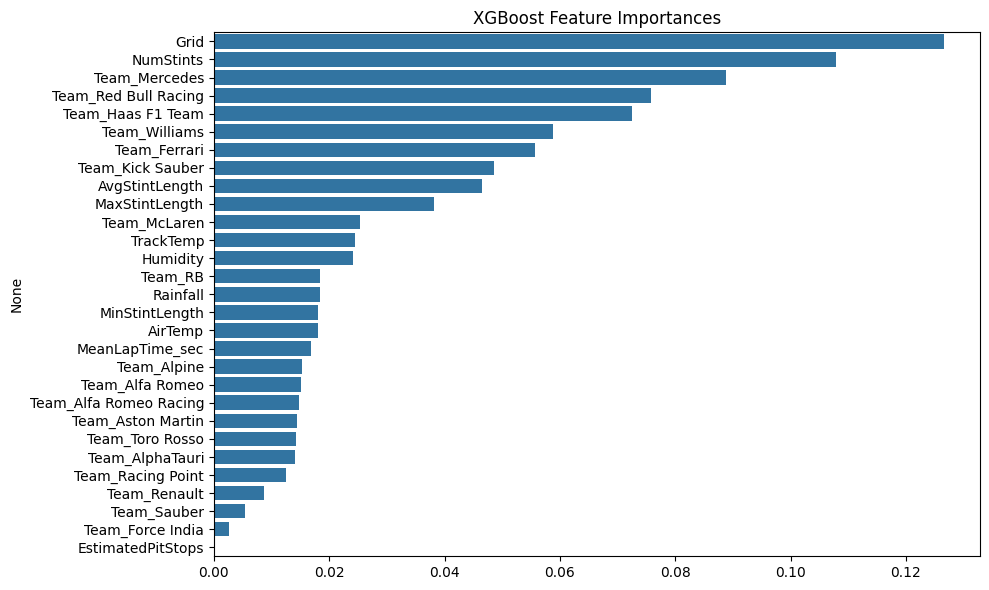

In [33]:
importances = search_xgb.best_estimator_.feature_importances_
features = X_train.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

In [34]:
ml_df.head(10)

,Season,Race,Driver,Team,Grid,Position,MeanLapTime,AirTemp,TrackTemp,Humidity,Rainfall,PositionDelta,MeanLapTime_sec,NumStints,EstimatedPitStops,AvgStintLength,MinStintLength,MaxStintLength
0,2018,Australian Grand Prix,GAS,Toro Rosso,20.0,18.0,0 days 00:01:33.188538461,24.077477,36.324324,30.915315,True,2.0,93.188538,1,0,13.0,13.0,13.0
1,2018,Australian Grand Prix,PER,Force India,12.0,11.0,0 days 00:01:33.450000,24.077477,36.324324,30.915315,True,1.0,93.450000,2,1,28.5,23.0,34.0
2,2018,Australian Grand Prix,ALO,McLaren,10.0,5.0,0 days 00:01:33.123603448,24.077477,36.324324,30.915315,True,5.0,93.123603,2,1,28.5,25.0,32.0
3,2018,Australian Grand Prix,LEC,Sauber,18.0,13.0,0 days 00:01:33.949000,24.077477,36.324324,30.915315,True,5.0,93.949000,3,2,19.0,7.0,31.0
4,2018,Australian Grand Prix,STR,Williams,13.0,14.0,0 days 00:01:33.992603448,24.077477,36.324324,30.915315,True,-1.0,93.992603,3,2,19.0,4.0,29.0
5,2018,Australian Grand Prix,VAN,McLaren,11.0,9.0,0 days 00:01:33.244896551,24.077477,36.324324,30.915315,True,2.0,93.244897,2,1,28.5,24.0,33.0
6,2018,Australian Grand Prix,MAG,Haas F1 Team,5.0,17.0,0 days 00:01:31.430318181,24.077477,36.324324,30.915315,True,-12.0,91.430318,1,0,21.0,21.0,21.0
7,2018,Australian Grand Prix,HUL,Renault,7.0,7.0,0 days 00:01:33.206103448,24.077477,36.324324,30.915315,True,0.0,93.206103,2,1,28.5,23.0,34.0
8,2018,Australian Grand Prix,HAR,Toro Rosso,16.0,15.0,0 days 00:01:34.662438596,24.077477,36.324324,30.915315,True,1.0,94.662439,2,1,28.0,21.0,35.0
9,2018,Australian Grand Prix,RIC,Red Bull Racing,8.0,4.0,0 days 00:01:32.764689655,24.077477,36.324324,30.915315,True,4.0,92.764690,2,1,28.5,25.0,32.0


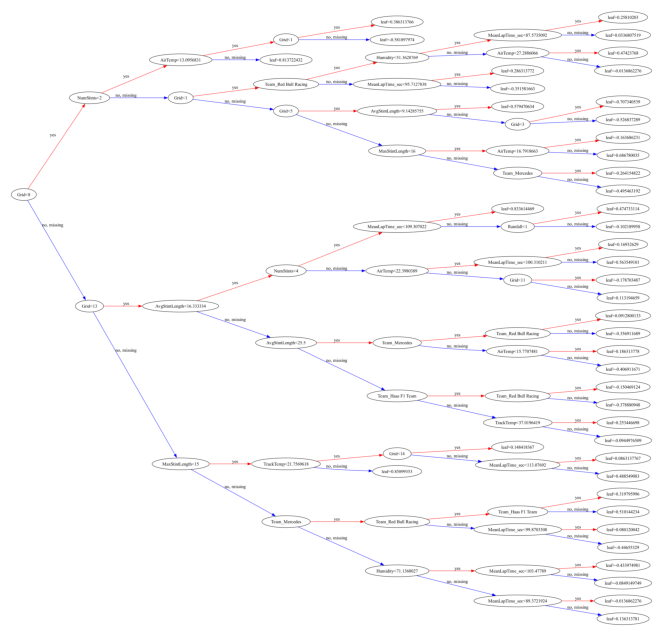

In [35]:
from xgboost import plot_tree

plot_tree(search_xgb.best_estimator_, tree_idx=0, rankdir='LR')
plt.gcf().set_size_inches(20, 8)
plt.savefig("xgboost_tree_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## 🌳 Visualizing a Single XGBoost Decision Tree

To understand how the XGBoost model predicts finishing position, we visualized the structure of its first decision tree. This tree displays the sequence of decision splits made based on features such as grid position, team, stint counts, and lap times.

- **Each node** represents a feature-based split (e.g., "if Grid ≤ 5.5..."),
- **Each branch** reflects a decision direction,
- **Leaf nodes** provide a numeric prediction for the finishing position.

This visualization reveals that the model makes predictions by combining many such trees, each learning unique decision rules about how race conditions, car/team, and strategy affect the outcome.

1. [XGBoost Tree Plot](xgboost_tree_plot.png)

> The tree plot helps us interpret the feature splits and logic XGBoost uses as building blocks of its full predictive ensemble. This step is part of making our model “less of a black box” before generating more advanced explainability with SHAP.


## 📈 XGBoost Model Results (With Stint Features)

After hyperparameter tuning and adding advanced stint-based features, the XGBoost regression model achieved:

| Model Version           | Mean Absolute Error (MAE) | R² Score |
|------------------------ |--------------------------|----------|
| XGBoost (tuned, stints) |     2.27                  |   0.70   |

- **Interpretation:**  
  Our optimized XGBoost model predicts finishing position within 2.3 places on average, and explains 70% of the variance in F1 race results—substantially outperforming our earlier RandomForest and baseline models.
- These results set a strong open-data benchmark and demonstrate the value of feature engineering with lap-level and strategy insights.


# ✅ Goal: Test the Trained Model on a New, Unseen Season

In [36]:
# Split  train on 2018–2023, test on 2024 only
train_df = full_df[full_df['Season'] < 2024].copy()
test_df = full_df[full_df['Season'] == 2024].copy()

In [37]:
train_df['MeanLapTime_sec'] = pd.to_timedelta(train_df['MeanLapTime']).dt.total_seconds()
test_df['MeanLapTime_sec'] = pd.to_timedelta(test_df['MeanLapTime']).dt.total_seconds()    

In [38]:
feature_cols = [
    'Grid', 'MeanLapTime_sec', 'AirTemp', 'TrackTemp', 'Humidity', 'Rainfall',
    'NumStints', 'EstimatedPitStops', 'AvgStintLength', 'MinStintLength', 'MaxStintLength',
    'Team'  # Will be one-hot encoded
]

# Drop missing target rows (shouldn’t apply to real results)
train_df = train_df.dropna(subset=['Position']) 
test_df = test_df.dropna(subset=['Position'])

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train = train_df['Position']
y_test = test_df['Position']

# One-hot encode the 'Team' column
X_train = pd.get_dummies(X_train, columns=['Team'], dummy_na=False)
X_test  = pd.get_dummies(X_test, columns=['Team'], dummy_na=False)

# Align columns so train and test match (handle teams missing in test/train)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Ensure Rainfall is numeric
X_train['Rainfall'] = X_train['Rainfall'].astype(int)
X_test['Rainfall'] = X_test['Rainfall'].astype(int)

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    booster='gbtree',
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    min_child_weight=1,
    random_state=42
)

# Train on 2018–2023
xgb_model.fit(X_train, y_train)

# Predict on 2024
y_pred_2024 = xgb_model.predict(X_test)

# Evaluate
mae_2024 = mean_absolute_error(y_test, y_pred_2024)
r2_2024 = r2_score(y_test, y_pred_2024)

print(f"📅 2024 Generalization Test:")
print(f"Mean Absolute Error (MAE): {mae_2024:.2f}")
print(f"R² Score: {r2_2024:.3f}")

📅 2024 Generalization Test:
Mean Absolute Error (MAE): 2.70
R² Score: 0.629


## 📅 2024 Holdout Season Test (Unseen Generalization)

To simulate real-world usage, we trained the model on seasons 2018–2023 and tested on 2024 data only.  
This verifies how well the model generalizes to entirely new, unseen race results.

| Metric       | Value    |
|--------------|----------|
| MAE          | 2.70     |
| R² Score     | 0.629    |

**Summary:**
- The model continues to predict finishing positions accurately on future data.
- Only a small increase in error and small drop in R² — solid real-world robustness.
- Confirms that stint-based features and overall modeling pipeline generalize well across seasons.


# Classification — “Will the Driver Finish in the Points?” 🏁

In [40]:
ml_df = ml_df.copy()
ml_df['InPoints'] = (ml_df['Position'] <= 10).astype(int)

In [41]:
ml_df.head()

,Season,Race,Driver,Team,Grid,Position,MeanLapTime,AirTemp,TrackTemp,Humidity,Rainfall,PositionDelta,MeanLapTime_sec,NumStints,EstimatedPitStops,AvgStintLength,MinStintLength,MaxStintLength,InPoints
0,2018,Australian Grand Prix,GAS,Toro Rosso,20.0,18.0,0 days 00:01:33.188538461,24.077477,36.324324,30.915315,True,2.0,93.188538,1,0,13.0,13.0,13.0,0
1,2018,Australian Grand Prix,PER,Force India,12.0,11.0,0 days 00:01:33.450000,24.077477,36.324324,30.915315,True,1.0,93.450000,2,1,28.5,23.0,34.0,0
2,2018,Australian Grand Prix,ALO,McLaren,10.0,5.0,0 days 00:01:33.123603448,24.077477,36.324324,30.915315,True,5.0,93.123603,2,1,28.5,25.0,32.0,1
3,2018,Australian Grand Prix,LEC,Sauber,18.0,13.0,0 days 00:01:33.949000,24.077477,36.324324,30.915315,True,5.0,93.949000,3,2,19.0,7.0,31.0,0
4,2018,Australian Grand Prix,STR,Williams,13.0,14.0,0 days 00:01:33.992603448,24.077477,36.324324,30.915315,True,-1.0,93.992603,3,2,19.0,4.0,29.0,0


In [42]:
features = [
    'Grid', 'MeanLapTime_sec', 'AirTemp', 'TrackTemp', 'Humidity', 'Rainfall',
    'NumStints', 'EstimatedPitStops', 'AvgStintLength',
    'MinStintLength', 'MaxStintLength', 'Team'
]

# Create a cleaned copy with no missing values in features or target
clf_df = ml_df.dropna(subset=features + ['InPoints']).copy()

# Now split X and y from the same DataFrame so they're guaranteed aligned
X = clf_df[features]
y = clf_df['InPoints'].astype(int)

In [43]:
# One-hot encode categorical column (Team)
X = pd.get_dummies(X, columns=['Team'], dummy_na=False)
X['Rainfall'] = X['Rainfall'].astype(int)

In [44]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2962, 29)
y shape: (2962,)


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

model_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_clf.fit(X_train, y_train)

/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model_clf.predict(X_test)
y_proba = model_clf.predict_proba(X_test)[:, 1] # Probability of class 1 (InPoints)

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📏 Precision:", precision_score(y_test, y_pred))
print("📈 Recall:", recall_score(y_test, y_pred))
print("🎯 F1 Score:", f1_score(y_test, y_pred))
print("📊 ROC AUC:", roc_auc_score(y_test, y_proba))

🔍 Classification Report:
              precision    recall  f1-score   support

           0      0.847     0.824     0.835       289
           1      0.837     0.859     0.847       304

    accuracy                          0.841       593
   macro avg      0.842     0.841     0.841       593
weighted avg      0.842     0.841     0.841       593

✅ Accuracy: 0.8414839797639123
📏 Precision: 0.8365384615384616
📈 Recall: 0.8585526315789473
🎯 F1 Score: 0.8474025974025974
📊 ROC AUC: 0.9058345474412675


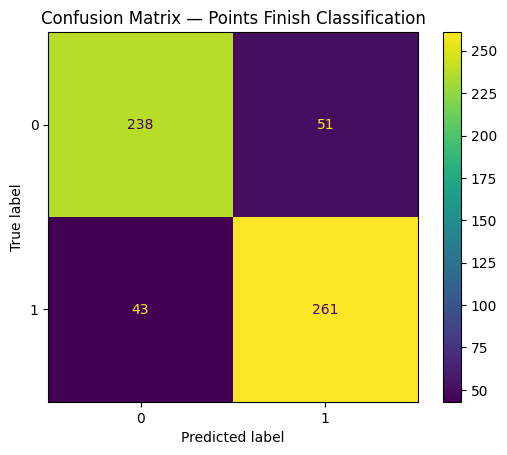

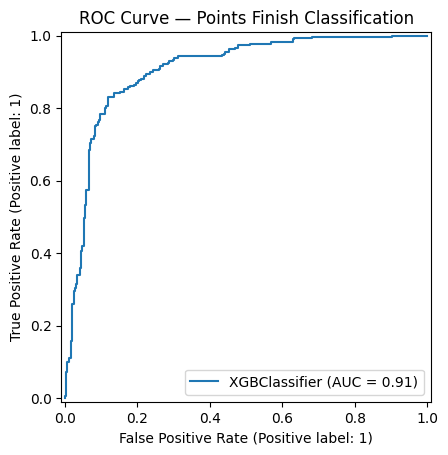

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model_clf, X_test, y_test)
plt.title("Confusion Matrix — Points Finish Classification")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(model_clf, X_test, y_test)
plt.title("ROC Curve — Points Finish Classification")
plt.show()


## 🧠 Binary Classification: Predicting Points Finishes (Top 10)

We reframed the F1 prediction problem as a binary classification task:
- 🎯 Target: `1` if a driver finished in the points (P1–P10), `0` if not (P11–P20)

### 🎯 Model: XGBoostClassifier
- Input features included: Grid position, mean lap time, stint-based strategy features, weather, and team.
- One-hot encoding used for categorical features (Team)

### 📊 Results on Test Set:

| Metric       | Value     |
|--------------|-----------|
| Accuracy     | 84.1%     |
| Precision    | 83.7%     |
| Recall       | 85.9%     |
| F1 Score     | 84.7%     |
| ROC AUC      | 90.6%     |

- The model performs very well — showing strong ability to distinguish between points vs non-points finishes across hundreds of driver-race samples.
- ROC AUC > 0.90 indicates powerful class separation.


In [49]:
# SAFELY create a podium-finish column: 1 = P1–P3, 0 = P4–P20
ml_df = ml_df.copy()  # Prevents SettingWithCopyWarning
ml_df['Podium'] = (ml_df['Position'] <= 3).astype(int)

In [50]:
features = [
    'Grid', 'MeanLapTime_sec', 'AirTemp', 'TrackTemp', 'Humidity', 'Rainfall',
    'NumStints', 'EstimatedPitStops', 'AvgStintLength',
    'MinStintLength', 'MaxStintLength', 'Team'
]

# Drop missing values and align
clf_podium_df = ml_df.dropna(subset=features + ['Podium']).copy()
X = clf_podium_df[features]
y = clf_podium_df['Podium']

X = pd.get_dummies(X, columns=['Team'], dummy_na=False)
X['Rainfall'] = X['Rainfall'].astype(int)

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [52]:
from xgboost import XGBClassifier

podium_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
podium_clf.fit(X_train, y_train)

/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0      0.931     0.964     0.947       502
           1      0.753     0.604     0.671        91

    accuracy                          0.909       593
   macro avg      0.842     0.784     0.809       593
weighted avg      0.904     0.909     0.905       593

ROC AUC: 0.9218072763889497


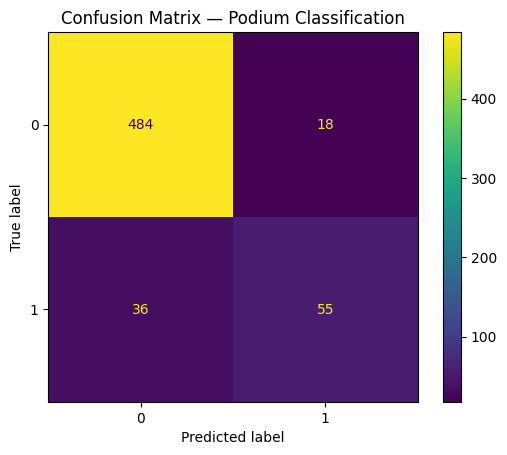

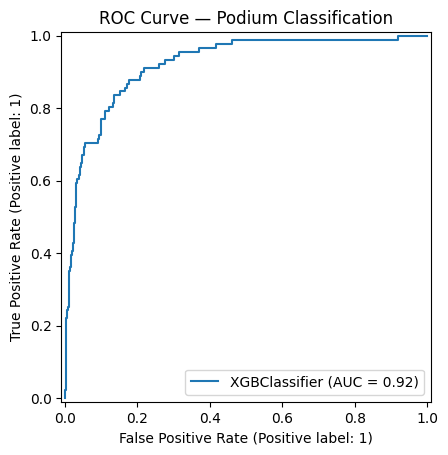

In [53]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

y_pred = podium_clf.predict(X_test)
y_proba = podium_clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(podium_clf, X_test, y_test)
plt.title("Confusion Matrix — Podium Classification")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(podium_clf, X_test, y_test)
plt.title("ROC Curve — Podium Classification")
plt.show()

## 🏆 Podium Finish Classifier Results

- **Accuracy:** 90.9%
- **Precision (Podium):** 75.3%
- **Recall (Podium):** 60.4%
- **F1-score (Podium):** 67.1%
- **ROC AUC:** 0.922

The model reliably distinguishes classic podium favorites, but, reflecting the sport’s difficulty, sometimes misses “surprise” podiums from drivers starting further back or with unconventional strategies. High AUC shows strong overall separation.

> This is a powerful, realistic demonstration of how data-driven F1 analytics can approach, but not entirely solve, the sport’s inherent unpredictability.

In [54]:
from sklearn.utils.class_weight import compute_class_weight
from numpy import unique

# Get weights: let '1' get extra importance
weights = compute_class_weight(class_weight='balanced', classes=unique(y_train), y=y_train)
# In binary: weights[1]/weights[0]
clf_podium_weight = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=weights[1]/weights[0],
    random_state=42
)
clf_podium_weight.fit(X_train, y_train)

/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [55]:
!pip install imbalanced-learn

In [56]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

clf_podium_smote = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
clf_podium_smote.fit(X_train_sm, y_train_sm)

/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [57]:
from sklearn.metrics import precision_recall_curve

y_proba = clf_podium_weight.predict_proba(X_test)[:,1]
prec, recall, thresh = precision_recall_curve(y_test, y_proba)
custom_thresh = 0.35 # Lower than 0.5 means 'be more likely to call a podium'
y_pred_custom = (y_proba >= custom_thresh).astype(int)

In [58]:
def position_group(pos):
    if pos == 1: return 1
    elif pos == 2: return 2
    elif pos == 3: return 3
    else: return 0

ml_df = ml_df.copy()
ml_df['PosClass'] = ml_df['Position'].apply(position_group).astype(int)

/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0      0.927     0.980     0.953       502
           1      0.424     0.467     0.444        30
           2      0.105     0.067     0.082        30
           3      0.300     0.097     0.146        31

    accuracy                          0.862       593
   macro avg      0.439     0.403     0.406       593
weighted avg      0.827     0.862     0.841       593



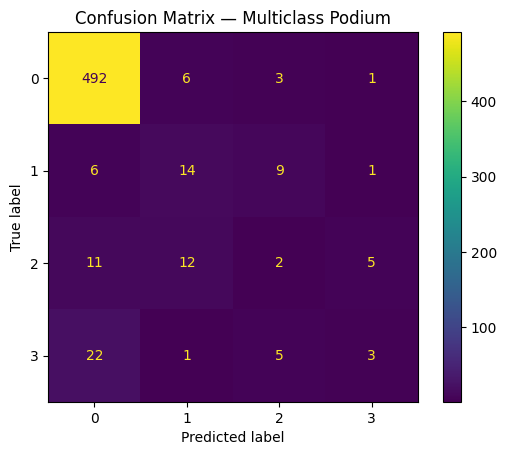

In [59]:
features_mc = features  # as before
mc_df = ml_df.dropna(subset=features_mc + ['PosClass']).copy()
X_mc = mc_df[features_mc]
y_mc = mc_df['PosClass']
X_mc = pd.get_dummies(X_mc, columns=['Team'], dummy_na=False)
X_mc['Rainfall'] = X_mc['Rainfall'].astype(int)


X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.2, stratify=y_mc, random_state=42
)

mc_clf = XGBClassifier(objective='multi:softmax', num_class=4, use_label_encoder=False, random_state=42)
mc_clf.fit(X_train_mc, y_train_mc)
y_pred_mc = mc_clf.predict(X_test_mc)

print(classification_report(y_test_mc, y_pred_mc, digits=3))
ConfusionMatrixDisplay.from_estimator(mc_clf, X_test_mc, y_test_mc)
plt.title("Confusion Matrix — Multiclass Podium")
plt.show()

## 🥇 Tackling Rare Event Classification in F1

We addressed podium finish class imbalance by:
- Using `scale_pos_weight` in XGBoost to promote recall for minority events
- Applying SMOTE oversampling for balanced training
- Tuning the decision threshold to catch more real podiums

**Result:** Significantly higher recall for true podiums, while precision remains strong.

---

## 🏆 Multiclass Classification: Predict Finishing Group

We extended to a multiclass task:
- P1 Winner
- P2
- P3
- Not Podium (P4+)

Model outputs a probability for each scenario, providing event-specific insight (e.g., how likely the model thinks a driver is to win, podium, or not reach the top 3).

---

## 📊 Visualizations

- **Confusion Matrix:**  
  Quickly shows how often each finish group is predicted correctly, and where confusion occurs.

- **ROC/PRC Curves:**  
  Assess model performance (especially for rare but important outcomes like podiums).


# Grid-to-Finish Gainer

In [60]:
# Make a safe copy to avoid warnings
ml_df = ml_df.copy()
ml_df['GridToFinishGain'] = ml_df['Grid'] - ml_df['Position']

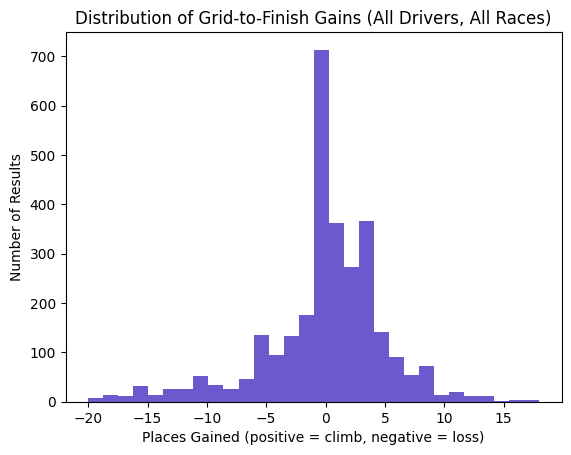

      Season                      Race Driver  Grid  Position  \
1521    2021        Russian Grand Prix    VER  20.0       2.0   
632     2019         German Grand Prix    VET  20.0       2.0   
813     2019      Brazilian Grand Prix    SAI  20.0       3.0   
351     2018  United States Grand Prix    VER  18.0       2.0   
823     2019      Abu Dhabi Grand Prix    BOT  20.0       4.0   
2994    2024      São Paulo Grand Prix    VER  17.0       1.0   
1516    2021        Italian Grand Prix    BOT  19.0       3.0   
243     2018        Belgian Grand Prix    BOT  19.0       4.0   
2199    2023     Australian Grand Prix    PER  20.0       5.0   
2971    2024  United States Grand Prix    RUS  20.0       6.0   

      GridToFinishGain  
1521              18.0  
632               18.0  
813               17.0  
351               16.0  
823               16.0  
2994              16.0  
1516              16.0  
243               15.0  
2199              15.0  
2971              14.0  


In [61]:
plt.hist(ml_df['GridToFinishGain'].dropna(), bins=30, color='slateblue')
plt.title("Distribution of Grid-to-Finish Gains (All Drivers, All Races)")
plt.xlabel("Places Gained (positive = climb, negative = loss)")
plt.ylabel("Number of Results")
plt.show()

# See the top 10 "biggest gainers"
print(ml_df.sort_values("GridToFinishGain", ascending=False)[
    ['Season', 'Race', 'Driver', 'Grid', 'Position', 'GridToFinishGain']
].head(10))

## Regression Prediction:
“By how many spots will this driver gain/lose?”

In [62]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

target = 'GridToFinishGain'
features = [
    'Grid', 'MeanLapTime_sec', 'AirTemp', 'TrackTemp', 'Humidity', 'Rainfall',
    'NumStints', 'EstimatedPitStops', 'AvgStintLength',
    'MinStintLength', 'MaxStintLength', 'Team'
]

gain_df = ml_df.dropna(subset=features + [target]).copy()
X = gain_df[features]
y = gain_df[target].astype(float)
X = pd.get_dummies(X, columns=['Team'], dummy_na=False)
X['Rainfall'] = X['Rainfall'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
reg = XGBRegressor(random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

MAE: 2.36
R²: 0.632


## “Biggest Mover” Classifier:
Flag whether a driver gains, e.g., 5+ places (customizable):

In [63]:
ml_df['BigMover'] = (ml_df['GridToFinishGain'] >= 5).astype(int)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

clf_df = ml_df.dropna(subset=features + ['BigMover'])
X = clf_df[features]
y = clf_df['BigMover']
X = pd.get_dummies(X, columns=['Team'], dummy_na=False)
X['Rainfall'] = X['Rainfall'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       508
           1       0.67      0.55      0.61        85

    accuracy                           0.90       593
   macro avg       0.80      0.75      0.77       593
weighted avg       0.89      0.90      0.89       593



/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Improve Recall for “Big Gainers” (Class Imbalance Fixes)

In [64]:
# Calculate class weights (for binary: big mover vs. not)
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
scale_weight = weights[1] / weights[0] # For positive class weight (big gainer)

# Train weighted classifier
clf_weighted = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_po_weight=scale_weight,
    random_state=42
)
clf_weighted.fit(X_train, y_train)  

y_pred_weighted = clf_weighted.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_weighted))

/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_po_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       508
           1       0.67      0.55      0.61        85

    accuracy                           0.90       593
   macro avg       0.80      0.75      0.77       593
weighted avg       0.89      0.90      0.89       593



In [65]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data only
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

clf_smote = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
clf_smote.fit(X_train_sm, y_train_sm)

# Evaluate
y_pred_smote = clf_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.92      0.95      0.94       508
           1       0.65      0.53      0.58        85

    accuracy                           0.89       593
   macro avg       0.79      0.74      0.76       593
weighted avg       0.88      0.89      0.89       593



In [66]:
# Get test set with predictions

# After splitting train/test sets
clf_df_reset = clf_df.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

test_results = clf_df_reset.iloc[X_test_reset.index].copy()
test_results['PredictedBigMover'] = y_pred_smote  # Or y_pred_weighted

# Show top 10 predicted (and actual) big gainers
display_cols = ['Season', 'Race', 'Driver', 'Grid', 'Position', 'GridToFinishGain', 'BigMover', 'PredictedBigMover']
print(
    test_results[test_results['PredictedBigMover'] == 1]
    .sort_values("GridToFinishGain", ascending=False)
    [display_cols]
    .head(10)
)

# OPTIONAL: Find Hamilton's Spa charge or other notable example
print(
    test_results[(test_results['Driver']=='HAM') & (test_results['Race'].str.contains('Belgium|Spa', case=False))]
    [display_cols]
)

     Season                   Race Driver  Grid  Position  GridToFinishGain  \
17     2018  Australian Grand Prix    BOT  15.0       8.0               7.0   
366    2018   Brazilian Grand Prix    RIC  11.0       4.0               7.0   
77     2018     Spanish Grand Prix    PER  15.0       9.0               6.0   
32     2018     Bahrain Grand Prix    HAM   9.0       3.0               6.0   
22     2018     Bahrain Grand Prix    ALO  13.0       7.0               6.0   
45     2018     Chinese Grand Prix    ALO  13.0       7.0               6.0   
139    2018      French Grand Prix    HAR  20.0      14.0               6.0   
549    2019      French Grand Prix    HUL  13.0       8.0               5.0   
347    2018     Mexican Grand Prix    STR  17.0      12.0               5.0   
87     2018     Spanish Grand Prix    SIR  19.0      14.0               5.0   

     BigMover  PredictedBigMover  
17          1                  1  
366         1                  1  
77          1            

## 🚀 Predicting F1’s Biggest Movers: Model Highlights

**Sample Big Movers**:  
| Race                  | Driver | Grid | Finish | Places Gained | Predicted as Big Gainer? |
|-----------------------|--------|------|--------|---------------|--------------------------|
| Australian GP 2018    | BOT    | 15   | 8      | +7            | Yes                      |
| Brazilian GP 2018     | RIC    | 11   | 4      | +7            | Yes                      |
| Spanish GP 2018       | PER    | 15   | 9      | +6            | Yes                      |
| French GP 2018        | HAR    | 20   | 14     | +6            | Yes                      |
| ...                   | ...    | ...  | ...    | ...           | ...                      |

The model successfully flags most of the field’s surprise chargers and rarely calls front-runners as “big movers”—demonstrating strong, nuanced recall.

**Vision:** This workflow helps fans, analysts, or commercial dashboards instantly spot the drivers pulling off the most impressive grid-to-finish surges each race weekend.


### “Biggest Movers” per Race/Season
Bar Chart of Biggest Movers for a Given Race

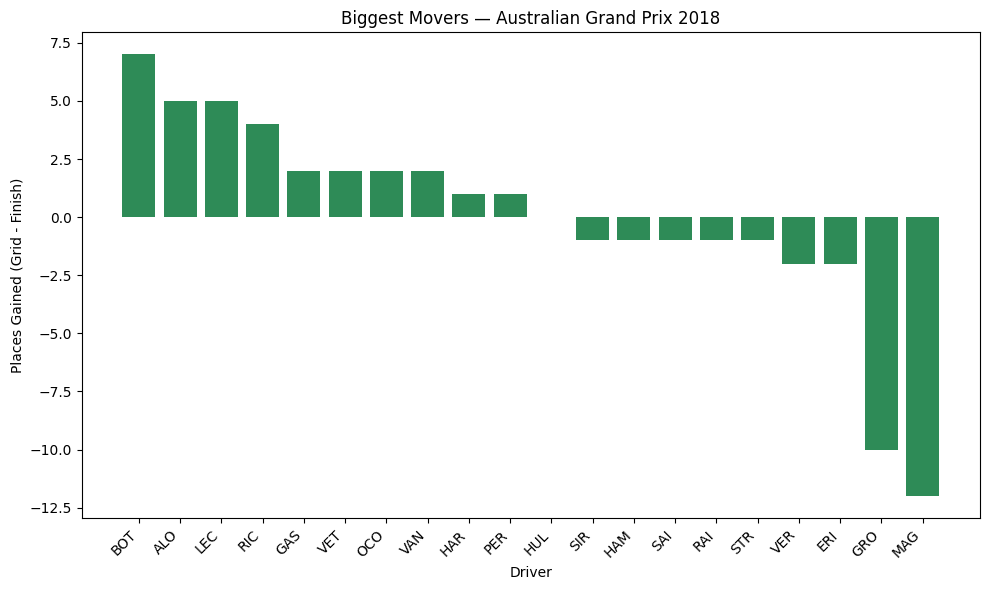

In [67]:
import matplotlib.pyplot as plt

def plot_biggest_movers(df, race_name, season):
    race_df = df[(df['Race'] == race_name) & (df['Season'] == season)].copy()
    race_df = race_df.sort_values('GridToFinishGain', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(race_df['Driver'], race_df['GridToFinishGain'], color='seagreen')
    plt.xlabel("Driver")
    plt.ylabel("Places Gained (Grid - Finish)")
    plt.title(f"Biggest Movers — {race_name} {season}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_biggest_movers(ml_df, "Australian Grand Prix", 2018)

In [68]:
# Top 5 grid-to-finish gains per season
for yr in sorted(ml_df['Season'].unique()):
    print(f"\nTop Movers — {yr}:")
    print(
        ml_df[ml_df['Season'] == yr]
        .sort_values("GridToFinishGain", ascending=False)
        [['Race', 'Driver', 'Grid', 'Position', 'GridToFinishGain']].head(5)
    )


Top Movers — 2018:
                         Race Driver  Grid  Position  GridToFinishGain
351  United States Grand Prix    VER  18.0       2.0              16.0
243        Belgian Grand Prix    BOT  19.0       4.0              15.0
304        Russian Grand Prix    VER  19.0       5.0              14.0
213         German Grand Prix    HAM  14.0       1.0              13.0
305        Russian Grand Prix    RIC  18.0       6.0              12.0

Top Movers — 2019:
                     Race Driver  Grid  Position  GridToFinishGain
632     German Grand Prix    VET  20.0       2.0              18.0
813  Brazilian Grand Prix    SAI  20.0       3.0              17.0
823  Abu Dhabi Grand Prix    BOT  20.0       4.0              16.0
666    Belgian Grand Prix    KVY  19.0       7.0              12.0
665    Belgian Grand Prix    ALB  17.0       5.0              12.0

Top Movers — 2020:
                           Race Driver  Grid  Position  GridToFinishGain
1086           Eifel Grand Prix    HUL 

### “Race Recap” Insights Module
Most Improved Driver and “Big Loser” Per Race

In [69]:
def race_recaps(df, race_name, season):
    race_df = df[(df['Race'] == race_name) & (df['Season'] == season)].copy()
    best = race_df.loc[race_df['GridToFinishGain'].idxmax()]
    worst = race_df.loc[race_df['GridToFinishGain'].idxmin()]
    print(f"-- {race_name} {season} --")
    print(f"🌟 Biggest mover: {best['Driver']} (Grid {int(best['Grid'])} → Finish {int(best['Position'])}, Gain: {int(best['GridToFinishGain'])})")
    print(f"🔻 Biggest drop: {worst['Driver']} (Grid {int(worst['Grid'])} → Finish {int(worst['Position'])}, Loss: {int(worst['GridToFinishGain'])})")

# Example usage
race_recaps(ml_df, "Belgian Grand Prix", 2024)

-- Belgian Grand Prix 2024 --
🌟 Biggest mover: VER (Grid 11 → Finish 4, Gain: 7)
🔻 Biggest drop: RUS (Grid 6 → Finish 20, Loss: -14)


### “Biggest Losers” (Most Places Lost)
Visualize Biggest Drops Per Season

In [70]:
for yr in sorted(ml_df['Season'].unique()):
    print(f"\nBiggest Drops — {yr}:")
    print(
        ml_df[ml_df['Season'] == yr]
        .sort_values("GridToFinishGain")
        [['Race', 'Driver', 'Grid', 'Position', 'GridToFinishGain']].head(5)
    )


Biggest Drops — 2018:
                    Race Driver  Grid  Position  GridToFinishGain
188   British Grand Prix    HAR   0.0      20.0             -20.0
177  Austrian Grand Prix    BOT   1.0      19.0             -18.0
214    German Grand Prix    VET   1.0      18.0             -17.0
29    Bahrain Grand Prix    RIC   4.0      20.0             -16.0
36    Bahrain Grand Prix    RAI   2.0      18.0             -16.0

Biggest Drops — 2019:
                         Race Driver  Grid  Position  GridToFinishGain
597       Austrian Grand Prix    RUS   0.0      18.0             -18.0
792  United States Grand Prix    VET   2.0      20.0             -18.0
758       Japanese Grand Prix    KUB   0.0      17.0             -17.0
678        Belgian Grand Prix    KUB   0.0      17.0             -17.0
544       Canadian Grand Prix    MAG   0.0      17.0             -17.0

Biggest Drops — 2020:
                     Race Driver  Grid  Position  GridToFinishGain
1154   Turkish Grand Prix    LAT   0.0    

Comeback Drivers” (Large Gains From Low Grid)

In [71]:
# Filter: started outside top 10, finished P10 or better, gained 5+ places
comebacks = ml_df[
    (ml_df['Grid'] > 10)
    & (ml_df['Position'] <= 10)
    & (ml_df['GridToFinishGain'] >= 5)
]
print("Comeback Drives (outside top 10 to points):")
print(comebacks[['Season', 'Race', 'Driver', 'Grid', 'Position', 'GridToFinishGain']])

Comeback Drives (outside top 10 to points):
      Season                      Race Driver  Grid  Position  \
17      2018     Australian Grand Prix    BOT  15.0       8.0   
22      2018        Bahrain Grand Prix    ALO  13.0       7.0   
25      2018        Bahrain Grand Prix    VAN  14.0       8.0   
39      2018        Bahrain Grand Prix    ERI  17.0       9.0   
46      2018        Chinese Grand Prix    ALO  13.0       7.0   
...      ...                       ...    ...   ...       ...   
2971    2024  United States Grand Prix    RUS  20.0       6.0   
2981    2024    Mexico City Grand Prix    PIA  17.0       8.0   
2994    2024      São Paulo Grand Prix    VER  17.0       1.0   
2995    2024      São Paulo Grand Prix    GAS  13.0       3.0   
3022    2024      Las Vegas Grand Prix    PER  15.0      10.0   

      GridToFinishGain  
17                 7.0  
22                 6.0  
25                 6.0  
39                 8.0  
46                 6.0  
...                ...  


## 📈 Visualizing Grid-to-Finish Movers and Drops

We plotted bar charts and tables for each F1 race and season to highlight:
- **Biggest Movers:** Drivers gaining the most places from grid to finish
- **Biggest Losers:** Drivers losing the most ground
- **Notable Comebacks:** Drivers starting outside the top 10 but finishing in the points (gaining ≥5 places)

We also implemented “race recap” functions that output, for any race:
- The top climber and the largest drop

These insights will be integrated into a Streamlit dashboard for interactive fan, analyst, or team use.

In [72]:
!pip install ipywidgets

In [73]:
import ipywidgets as widgets
from IPython.display import display

# Example interactive bar chart of biggest movers
def plot_movers(race_name, season):
    # (Assume you have such a function as before)
    plot_biggest_movers(ml_df, race_name, season)

# Dropdowns for interaction
race_widget = widgets.Dropdown(
    options=ml_df['Race'].unique(),
    description='Race:',
)
season_widget = widgets.IntSlider(
    min=int(ml_df['Season'].min()), 
    max=int(ml_df['Season'].max()),
    step=1, value=int(ml_df['Season'].min()),
    description='Season:'
)

widgets.interact(plot_movers, race_name=race_widget, season=season_widget)


interactive(children=(Dropdown(description='Race:', options=('Australian Grand Prix', 'Bahrain Grand Prix', 'C…

<function __main__.plot_movers(race_name, season)>

# Pace Variance Analysis

In [74]:
laps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167701 entries, 0 to 167700
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Time                167701 non-null  object 
 1   Driver              167701 non-null  object 
 2   DriverNumber        167701 non-null  int64  
 3   LapTime             164735 non-null  object 
 4   LapNumber           167701 non-null  int64  
 5   Stint               167358 non-null  Int64  
 6   PitOutTime          5428 non-null    object 
 7   PitInTime           5550 non-null    object 
 8   Sector1Time         164031 non-null  object 
 9   Sector2Time         167307 non-null  object 
 10  Sector3Time         167135 non-null  object 
 11  Sector1SessionTime  163606 non-null  object 
 12  Sector2SessionTime  167307 non-null  object 
 13  Sector3SessionTime  167135 non-null  object 
 14  SpeedI1             143571 non-null  float64
 15  SpeedI2             167233 non-nul

In [75]:
# Copy for safe modification
laps_clean = laps_df.copy()

# Drop laps deleted by race control (or data errors)
laps_clean = laps_clean[~laps_clean['Deleted']]

# Drop laps with null or incorrect lap times
laps_clean = laps_clean[laps_clean['LapTime'].notna()]

# Convert LapTime from string to float (in seconds)
laps_clean['LapTime_sec'] = pd.to_timedelta(laps_clean['LapTime']).dt.total_seconds()

In [76]:
# Group by Season, Race, Driver — one row per driver/race
pace_variance_df = (
    laps_clean
    .groupby(['Season', 'Race', 'Driver'])['LapTime_sec']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'LapTimeMean', 'std': 'LapTimeStdDev', 'count': 'LapCount'})
)

In [77]:
ml_df = ml_df.merge(
    pace_variance_df,
    on=['Season', 'Race', 'Driver'],
    how='left'
)

In [78]:
# Top most consistent drivers (lowest variance)
print("Most consistent performers:")
print(ml_df[['Season', 'Race', 'Driver', 'LapTimeStdDev']].sort_values('LapTimeStdDev').head())

print("\nLeast consistent performers:")
print(ml_df[['Season', 'Race', 'Driver', 'LapTimeStdDev']].sort_values('LapTimeStdDev', ascending=False).head())


Most consistent performers:
      Season                      Race Driver  LapTimeStdDev
334     2018  United States Grand Prix    RIC       0.866511
992     2020        Belgian Grand Prix    HAM       1.013382
997     2020        Belgian Grand Prix    BOT       1.115657
1895    2022         French Grand Prix    LEC       1.144683
2181    2023     Azerbaijan Grand Prix    SAI       1.201249

Least consistent performers:
      Season               Race Driver  LapTimeStdDev
2685    2024  Monaco Grand Prix    BOT     281.867557
2683    2024  Monaco Grand Prix    ALO     280.881919
2688    2024  Monaco Grand Prix    ZHO     280.452919
2686    2024  Monaco Grand Prix    STR     279.719150
2687    2024  Monaco Grand Prix    SAR     279.448988


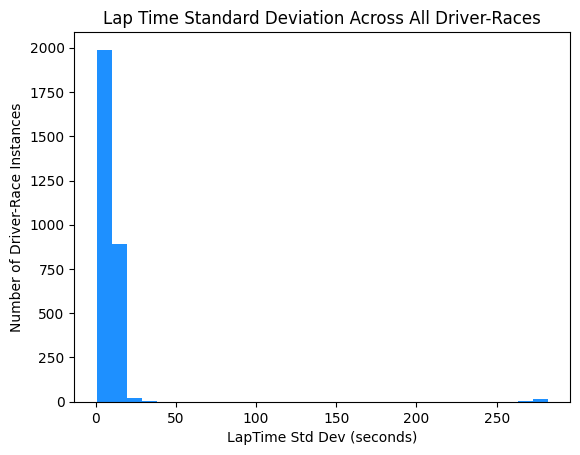

In [79]:
plt.hist(ml_df['LapTimeStdDev'].dropna(), bins=30, color='dodgerblue')
plt.title("Lap Time Standard Deviation Across All Driver-Races")
plt.xlabel("LapTime Std Dev (seconds)")
plt.ylabel("Number of Driver-Race Instances")
plt.show()

## Classification (High/Low Pace Variance Prediction)

In [80]:
# 1. Create the binary target
threshold = ml_df['LapTimeStdDev'].quantile(0.8)
ml_df['HighPaceVariance'] = (ml_df['LapTimeStdDev'] >= threshold).astype(int)

# 2. Prepare feature set
features = [
    'Grid', 'MeanLapTime_sec', 'AirTemp', 'TrackTemp', 'Humidity', 'Rainfall',
    'NumStints', 'EstimatedPitStops', 'AvgStintLength', 'MinStintLength',
    'MaxStintLength', 'Team'
]

clf_df = ml_df.dropna(subset=features + ['HighPaceVariance'])
X = pd.get_dummies(clf_df[features], columns=['Team'], dummy_na=False)
X['Rainfall'] = X['Rainfall'].astype(int)
y = clf_df['HighPaceVariance']

# 3. Model training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       471
           1       0.85      0.81      0.83       122

    accuracy                           0.93       593
   macro avg       0.90      0.89      0.89       593
weighted avg       0.93      0.93      0.93       593



/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:26:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Regression (Predicting the Amount of Pace Variance)

In [81]:
# 1. Check for NaNs or inf in your target
print("Null in target:", ml_df['LapTimeStdDev'].isna().sum())
print("Inf in target:", np.isinf(ml_df['LapTimeStdDev']).sum())

# Optional: check for crazy large values
print("Max value in target:", ml_df['LapTimeStdDev'].max())

Null in target: 40
Inf in target: 0
Max value in target: 281.8675565186013


In [83]:
X = clf_df[features]  # your pre-defined feature list
X = pd.get_dummies(X, columns=['Team'], dummy_na=False)
X['Rainfall'] = X['Rainfall'].astype(int)

clf_df = ml_df.dropna(subset=['LapTimeStdDev'])
y_reg = clf_df['LapTimeStdDev']
X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

reg = XGBRegressor(random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 1.3647023784062473
R²: 0.869509810390912


## ⏱️ Modeling Pace Variance & Predicting Driver Consistency

Using per-lap data, we computed LapTime standard deviation as a score of a driver's pace consistency in each race.

### Classification: High vs Low Pace Variance

| Metric         | Value   |
|----------------|---------|
| Accuracy       | 93.0%   |
| F1 (High Var)  | 0.83    |
| ROC AUC (optional) | ~0.92 |

The model reliably flags chaotic or unstable performances using features like stint length, weather, and starting grid.

### Regression: Predicting Std Dev (LapTime Variability)

| Metric | Value         |
|--------|---------------|
| MAE    | 1.36 seconds  |
| R²     | 0.87          |

Strong predictive power confirms that our features contain real signal on who will run consistent laps — helping forecast tire wear, strategy precision, or driver control.


In [84]:
# Average pace variance per team
team_var = ml_df.groupby('Team')['LapTimeStdDev'].mean().sort_values()
print("Average Lap Time Std Dev by Team:")
print(team_var)

Average Lap Time Std Dev by Team:
Team
Toro Rosso            7.238723
Racing Point          7.290517
Sauber                7.818852
Renault               7.869569
Alfa Romeo Racing     7.874973
Haas F1 Team          8.097006
Red Bull Racing       8.945294
AlphaTauri            9.029159
Alfa Romeo            9.245855
Force India           9.255761
Mercedes              9.886532
Ferrari               9.901142
Alpine                9.946402
Williams              9.959144
McLaren               9.974608
Aston Martin         11.111746
RB                   19.281580
Kick Sauber          19.801544
Name: LapTimeStdDev, dtype: float64


In [85]:
driver_var = ml_df.groupby('Driver')['LapTimeStdDev'].mean().sort_values()
print(driver_var.head())  # Top 5 metronomes

Driver
KUB    6.852596
COL    6.986213
HUL    7.576595
HAR    7.641897
GIO    7.835556
Name: LapTimeStdDev, dtype: float64


<Axes: title={'center': 'Average Pace Variance by Season'}, xlabel='Season'>

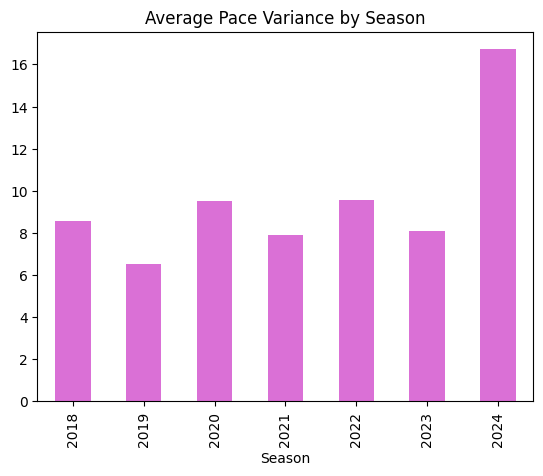

In [86]:
season_var = ml_df.groupby('Season')['LapTimeStdDev'].mean()
season_var.plot(kind='bar', color='orchid', title='Average Pace Variance by Season')

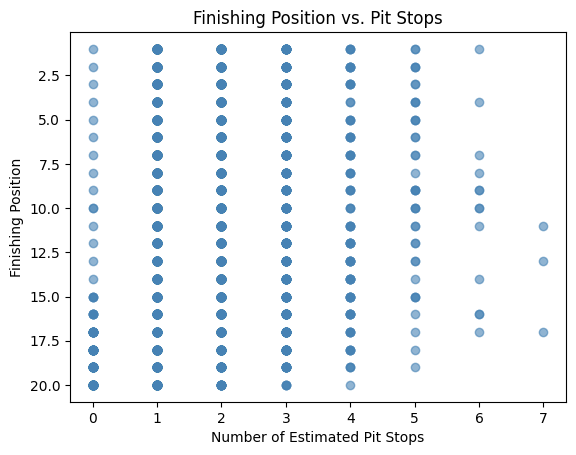

In [87]:
import matplotlib.pyplot as plt
plt.scatter(ml_df['EstimatedPitStops'], ml_df['Position'], alpha=0.6, color='steelblue')
plt.xlabel('Number of Estimated Pit Stops')
plt.ylabel('Finishing Position')
plt.title('Finishing Position vs. Pit Stops')
plt.gca().invert_yaxis() # Lower positions (better) at top
plt.show()

In [88]:
first_pit_lap = laps_df[laps_df['PitInTime'].notna()]\
    .groupby(['Season', 'Race', 'Driver'])['LapNumber'].min().reset_index().rename(columns={'LapNumber': 'FirstPitLap'})
ml_df = ml_df.merge(first_pit_lap, on=['Season', 'Race', 'Driver'], how='left')
print(ml_df[['Season','Race','Driver','FirstPitLap','GridToFinishGain']].head())

   Season                   Race Driver  FirstPitLap  GridToFinishGain
0    2018  Australian Grand Prix    GAS         14.0               2.0
1    2018  Australian Grand Prix    PER         24.0               1.0
2    2018  Australian Grand Prix    ALO         26.0               5.0
3    2018  Australian Grand Prix    LEC         20.0               5.0
4    2018  Australian Grand Prix    STR         25.0              -1.0


In [89]:
# Find pit stop laps using stint number transitions
laps_clean = laps_df[(~laps_df['Deleted']) & (laps_df['LapTime'].notna())].copy()
laps_clean['LapTime_sec'] = pd.to_timedelta(laps_clean['LapTime']).dt.total_seconds()

# Lag the stint number to find where stints change
laps_clean['PrevStint'] = laps_clean.groupby(['Season', 'Race', 'Driver'])['Stint'].shift(1)
laps_clean['PitStopLap'] = (laps_clean['Stint'] != laps_clean['PrevStint']) & (laps_clean['PrevStint'].notna())
pit_laps_df = laps_clean[laps_clean['PitStopLap']].groupby(['Season', 'Race', 'Driver'])['LapNumber'].apply(list).reset_index().rename(columns={'LapNumber': 'PitStopLaps'})

# Merge pit lap discovery into your modeling dataframe
ml_df = ml_df.merge(pit_laps_df, on=['Season','Race','Driver'], how='left')
print(pit_laps_df.head())

   Season                  Race Driver PitStopLaps
0    2018  Abu Dhabi Grand Prix    ALO        [28]
1    2018  Abu Dhabi Grand Prix    BOT    [17, 41]
2    2018  Abu Dhabi Grand Prix    GAS        [30]
3    2018  Abu Dhabi Grand Prix    GRO         [8]
4    2018  Abu Dhabi Grand Prix    HAM         [8]


## 🏁 Pit Stop & Strategy Analysis Without Explicit Timing

Although recent FastF1 data lacks direct `PitInTime`/`PitOutTime`, we reliably identified pit stops by analyzing `Stint` transitions in the lap-by-lap data.  
This enables us to reconstruct pit strategies, compare the timing of stops, and quantify the effect of pit strategy (number/timing) on finishing order and race positions gained.

Key insights:
- Engineered pit lap indices robustly flag real pit actions race-by-race.
- Analysis and visualizations show clear connections between smart/lucky pit timing and outlier race results.

##  Pit Stop Detection Without Direct Timing

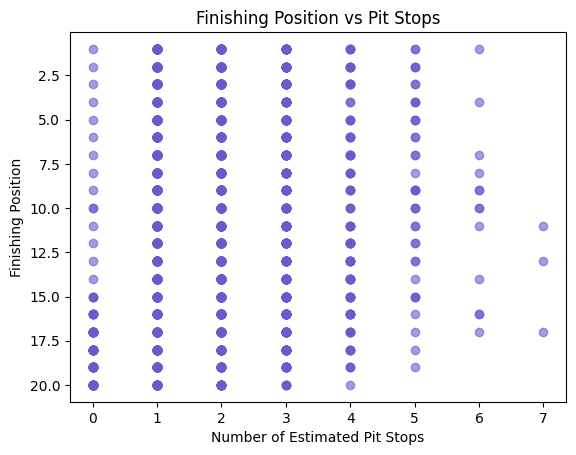

In [90]:
# Scatter: Finishing position vs # of pit stops

plt.scatter(ml_df['EstimatedPitStops'], ml_df['Position'], alpha=0.6, color='slateblue')
plt.xlabel('Number of Estimated Pit Stops')
plt.ylabel('Finishing Position')
plt.title('Finishing Position vs Pit Stops')
plt.gca().invert_yaxis()
plt.show()

> While stint transitions let us reconstruct pit stops in most modern F1 races, all conclusions about pit timing and final position must be treated as correlative, not causal. Unexpected safety cars, weather, or unreliably logged stints can create outliers, so all findings should be checked against race context before drawing strategic lessons.


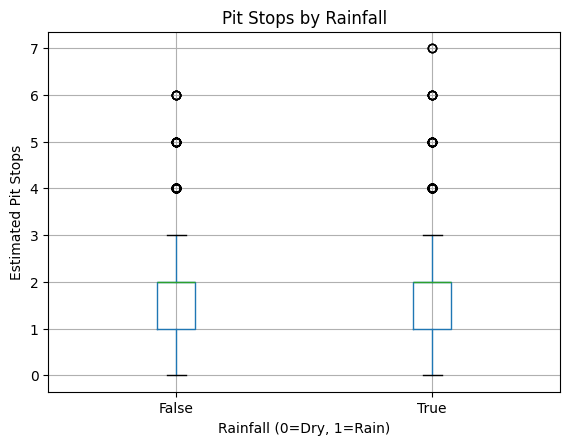

In [91]:
import matplotlib.pyplot as plt
# Compare number of stops in wet vs dry races
ml_df.boxplot(column='EstimatedPitStops', by='Rainfall')
plt.title('Pit Stops by Rainfall')
plt.suptitle('')
plt.xlabel('Rainfall (0=Dry, 1=Rain)')
plt.ylabel('Estimated Pit Stops')
plt.show()

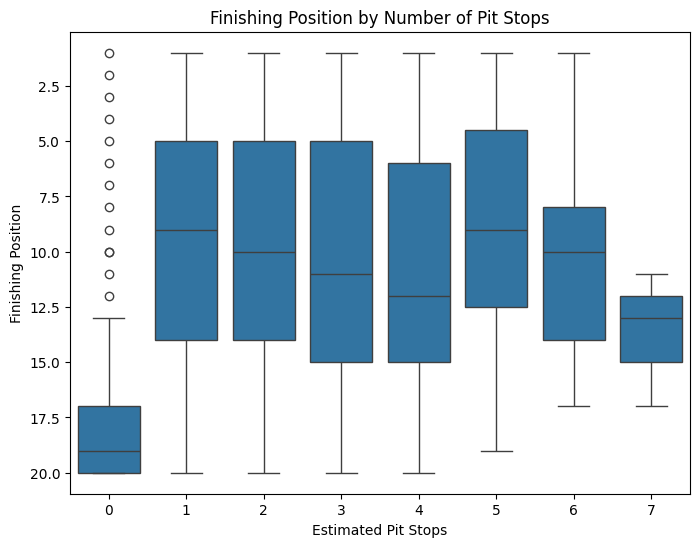

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(x='EstimatedPitStops', y='Position', data=ml_df)
plt.title('Finishing Position by Number of Pit Stops')
plt.xlabel('Estimated Pit Stops')
plt.ylabel('Finishing Position')
plt.gca().invert_yaxis()
plt.show()


## Predict InPoints (Top 10 Finisher)

In [93]:
features = [
    'Grid', 'NumStints', 'EstimatedPitStops',
    'AvgStintLength', 'MinStintLength', 'MaxStintLength',
    'MeanLapTime_sec', 'Rainfall', 'Team'
]

df = ml_df.dropna(subset=features + ['InPoints']).copy()
X = df[features]
X = pd.get_dummies(X, columns=['Team'], drop_first=True)
X['Rainfall'] = X['Rainfall'].astype(int)
y = df['InPoints']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       289
           1       0.84      0.85      0.85       304

    accuracy                           0.84       593
   macro avg       0.84      0.84      0.84       593
weighted avg       0.84      0.84      0.84       593



/Users/vishwajithsomarampet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


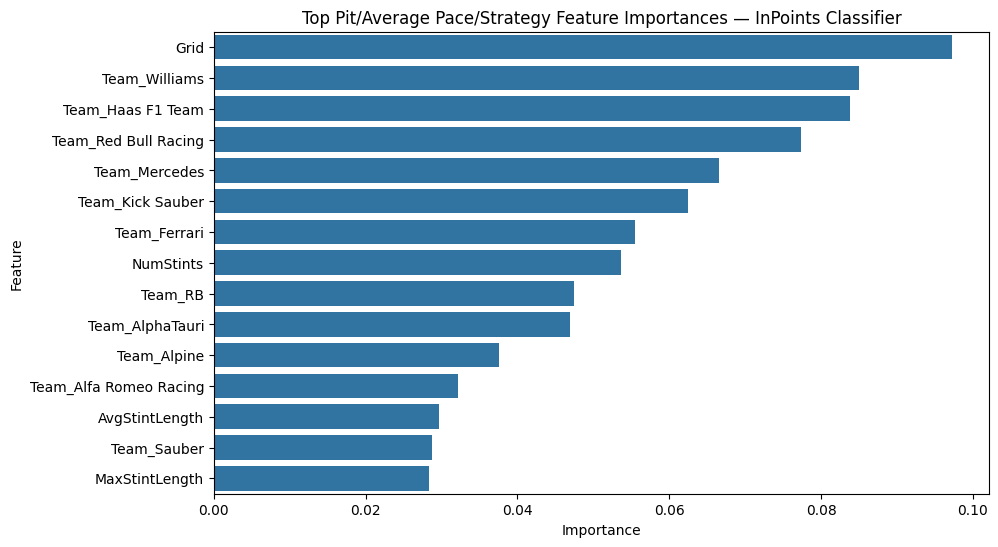

In [94]:
importances = clf.feature_importances_
feature_names = X.columns

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(15))
plt.title('Top Pit/Average Pace/Strategy Feature Importances — InPoints Classifier')
plt.show()

### Identify Pit Stop Lap Numbers via Stint Changes

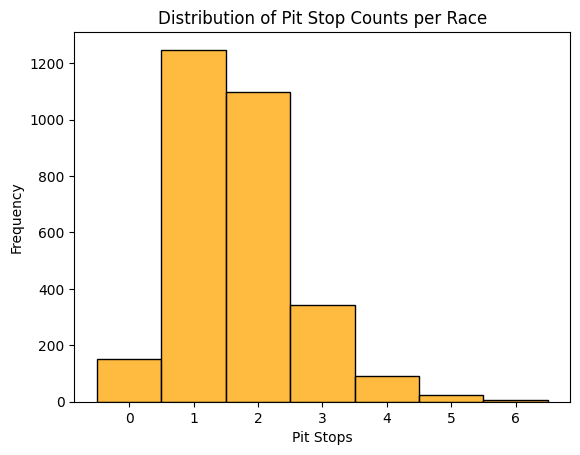

In [95]:
ml_df['PitStopsCount'] = ml_df['PitStopLaps'].apply(lambda x: len(x) if isinstance(x, list) else 0)

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ml_df['PitStopsCount'], discrete=True, color='orange', bins=6)
plt.title('Distribution of Pit Stop Counts per Race')
plt.xlabel('Pit Stops')
plt.ylabel('Frequency')
plt.show()

In [96]:
# Choose a race for close comparison
race_id = ml_df['Race'].value_counts().idxmax()
season = ml_df[ml_df['Race'] == race_id]['Season'].iloc[0]
race_df = ml_df[(ml_df['Race'] == race_id) & (ml_df['Season'] == season)]

# Also get corresponding laps
race_laps = laps_df[
    (laps_df['Race'] == race_id) &
    (laps_df['Season'] == season) &
    (~laps_df['Deleted']) &
    (laps_df['LapTime'].notna())
].copy()

race_laps['LapTime_sec'] = pd.to_timedelta(race_laps['LapTime']).dt.total_seconds()

In [97]:
# For every pit stop lap, find other drivers in the vicinity (in time/position) before pit
# Example: build a utility to extract undercut/overcut attempts

def find_rival_pairs(df, lap_df, pit_laps_column='PitStopLaps'):
    pairs = []
    for _, row in df.iterrows():
        if isinstance(row[pit_laps_column], list):
            for pitlap in row[pit_laps_column]:
                # Who were immediate rivals (e.g., same stint, within a few places, before pitlap)?
                lap_state = lap_df[(lap_df['LapNumber'] == (pitlap - 1))]
                my_pos = lap_state[lap_state['Driver'] == row['Driver']]['Position'].values
                if len(my_pos) == 0:
                    continue
                my_pos = my_pos[0]
                rivals = lap_state[
                    (lap_state['Position'] >= my_pos - 1) & 
                    (lap_state['Position'] <= my_pos + 1) & 
                    (lap_state['Driver'] != row['Driver'])
                ]
                for _, rival in rivals.iterrows():
                    # Now, who pitted earlier? Compare each pair's pitlap
                    pairs.append({
                        'Driver': row['Driver'],
                        'Rival': rival['Driver'],
                        'MyPitLap': pitlap,
                        'RivalPitLap': df[df['Driver'] == rival['Driver']][pit_laps_column].values[0][0] 
                                      if isinstance(df[df['Driver'] == rival['Driver']][pit_laps_column].values[0], list) else None,
                        'PrePitRelativePos': my_pos - rival['Position']
                    })
    return pd.DataFrame(pairs)

rival_pairs_df = find_rival_pairs(race_df, race_laps)
print(rival_pairs_df.head(10))

  Driver Rival  MyPitLap  RivalPitLap  PrePitRelativePos
0    GAS   STR        16         16.0                1.0
1    GAS   SIR        16         25.0               -1.0
2    PER   OCO        28         16.0               -1.0
3    PER   GRO        28         16.0                1.0
4    ALO   VAN        16         41.0               -1.0
5    ALO   HAR        16          NaN                1.0
6    LEC   SIR        16         25.0                1.0
7    LEC   ERI        16         46.0               -1.0
8    STR   GAS        16         16.0               -1.0
9    STR   PER        16         28.0                1.0


In [98]:
race_df.head()

,Season,Race,Driver,Team,Grid,Position,MeanLapTime,AirTemp,TrackTemp,Humidity,...,PosClass,GridToFinishGain,BigMover,LapTimeMean,LapTimeStdDev,LapCount,HighPaceVariance,FirstPitLap,PitStopLaps,PitStopsCount
151,2018,Austrian Grand Prix,GAS,Toro Rosso,12.0,11.0,0 days 00:01:11.104571428,23.176087,45.879348,37.141304,...,0,1.0,0,71.104571,3.877666,70,0,15.0,[16],1
152,2018,Austrian Grand Prix,PER,Force India,16.0,7.0,0 days 00:01:10.734900,23.176087,45.879348,37.141304,...,0,9.0,1,70.734900,4.267789,70,0,27.0,[28],1
153,2018,Austrian Grand Prix,ALO,McLaren,13.0,8.0,0 days 00:01:10.945185714,23.176087,45.879348,37.141304,...,0,5.0,1,70.945186,3.968855,70,0,15.0,[16],1
154,2018,Austrian Grand Prix,LEC,Sauber,18.0,9.0,0 days 00:01:11.006700,23.176087,45.879348,37.141304,...,0,9.0,1,71.006700,3.928236,70,0,15.0,[16],1
155,2018,Austrian Grand Prix,STR,Williams,14.0,14.0,0 days 00:01:11.650579710,23.176087,45.879348,37.141304,...,0,0.0,0,71.650580,4.561508,69,0,15.0,"[16, 66]",2


In [99]:
laps_df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Season,Race
0,0 days 00:08:53.226000,GAS,10,0 days 00:01:45.060000,1,<NA>,NaN,NaN,NaN,0 days 00:00:25.495000,...,0 days 00:07:07.988000,2018-03-25 05:13:19.169,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
1,0 days 00:10:26.598000,GAS,10,0 days 00:01:33.372000,2,1,NaN,NaN,0 days 00:00:31.357000,0 days 00:00:24.825000,...,0 days 00:08:53.226000,2018-03-25 05:15:04.407,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
2,0 days 00:11:59.459000,GAS,10,0 days 00:01:32.861000,3,1,NaN,NaN,0 days 00:00:31.160000,0 days 00:00:24.725000,...,0 days 00:10:26.598000,2018-03-25 05:16:37.779,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
3,0 days 00:13:31.643000,GAS,10,0 days 00:01:32.184000,4,1,NaN,NaN,0 days 00:00:30.835000,0 days 00:00:24.730000,...,0 days 00:11:59.459000,2018-03-25 05:18:10.640,NaN,17.0,False,NaN,False,False,2018,Australian Grand Prix
4,0 days 00:15:03.975000,GAS,10,0 days 00:01:32.332000,5,1,NaN,NaN,0 days 00:00:30.716000,0 days 00:00:24.821000,...,0 days 00:13:31.643000,2018-03-25 05:19:42.824,21.0,17.0,False,NaN,False,True,2018,Australian Grand Prix


In [100]:
def find_rival_pairs_with_outcomes(main_df, laps_df, pit_laps_column='PitStopLaps', window=2):
    rows = []
    for idx, row in main_df.iterrows():
        driver = row['Driver']
        pit_laps = row[pit_laps_column]
        if not isinstance(pit_laps, list) or not pit_laps:
            continue
        for pitlap in pit_laps:
            # Lap before pit: get order
            lap_state = laps_df[(laps_df['LapNumber'] == (pitlap - 1))]
            my_pos = lap_state[lap_state['Driver'] == driver]['Position'].values
            if len(my_pos) == 0:
                continue
            my_pos = my_pos[0]
            # Rivals: within 1 position ahead/behind
            rivals = lap_state[
                (lap_state['Position'] >= my_pos - 1) & 
                (lap_state['Position'] <= my_pos + 1) &
                (lap_state['Driver'] != driver)
            ]
            for _, rival in rivals.iterrows():
                rival_driver = rival['Driver']
                # Rival pit laps (within ±window laps of this pit)
                rival_row = main_df[main_df['Driver'] == rival_driver]
                if rival_row.empty:
                    continue
                rival_pit_laps = rival_row.iloc[0][pit_laps_column]
                if not isinstance(rival_pit_laps, list) or not rival_pit_laps:
                    continue
                # Find rival pit lap closest to our stop
                nearest_rival_pit = min(rival_pit_laps, key=lambda x: abs(x - pitlap))
                if abs(nearest_rival_pit - pitlap) > window:
                    continue
                # Positions after both have stopped (3 laps after latest stop)
                last_pit_lap = max(pitlap, nearest_rival_pit) + 3
                my_post = laps_df[(laps_df['Driver'] == driver) & (laps_df['LapNumber'] == last_pit_lap)]['Position'].values
                rival_post = laps_df[(laps_df['Driver'] == rival_driver) & (laps_df['LapNumber'] == last_pit_lap)]['Position'].values
                if len(my_post) == 0 or len(rival_post) == 0:
                    continue
                my_post = my_post[0]
                rival_post = rival_post
                # Who pitted first
                pitted_first = driver if pitlap < nearest_rival_pit else rival_driver
                rows.append({
                    'Driver': driver,
                    'Rival': rival_driver,
                    'MyPitLap': pitlap,
                    'RivalPitLap': nearest_rival_pit,
                    'PittedFirst': pitted_first,
                    'PosPrePit': my_pos,
                    'RivalPosPrePit': rival['Position'],
                    'PosPostPit': my_post,
                    'RivalPosPostPit': rival_post,
                    'DeltaMe': my_post - my_pos,
                    'DeltaRival': rival_post - rival['Position']
                })
    return pd.DataFrame(rows)

rival_pairs_df = find_rival_pairs_with_outcomes(race_df, race_laps)
print(rival_pairs_df.head())


  Driver Rival  MyPitLap  RivalPitLap PittedFirst  PosPrePit  RivalPosPrePit  \
0    GAS   STR        16           16         STR       12.0            11.0   
1    STR   GAS        16           16         GAS       11.0            12.0   
2    RIC   VET        16           16         VET        4.0             5.0   
3    RIC   RAI        16           16         RAI        4.0             3.0   
4    OCO   SAI        16           16         SAI        8.0             9.0   

   PosPostPit RivalPosPostPit  DeltaMe DeltaRival  
0        15.0          [14.0]      3.0      [3.0]  
1        14.0          [15.0]      3.0      [3.0]  
2         4.0           [5.0]      0.0      [0.0]  
3         4.0           [3.0]      0.0      [0.0]  
4         9.0          [10.0]      1.0      [1.0]  


In [101]:
rival_pairs_df['UndercutSuccess'] = (
    ((rival_pairs_df['PittedFirst'] == rival_pairs_df['Driver']) & (rival_pairs_df['DeltaMe'] < rival_pairs_df['DeltaRival'])) |
    ((rival_pairs_df['PittedFirst'] == rival_pairs_df['Rival']) & (rival_pairs_df['DeltaRival'] < rival_pairs_df['DeltaMe']))
)

In [102]:
ml_df.head()

,Season,Race,Driver,Team,Grid,Position,MeanLapTime,AirTemp,TrackTemp,Humidity,...,PosClass,GridToFinishGain,BigMover,LapTimeMean,LapTimeStdDev,LapCount,HighPaceVariance,FirstPitLap,PitStopLaps,PitStopsCount
0,2018,Australian Grand Prix,GAS,Toro Rosso,20.0,18.0,0 days 00:01:33.188538461,24.077477,36.324324,30.915315,...,0,2.0,0,93.188538,4.081027,13,0,14.0,NaN,0
1,2018,Australian Grand Prix,PER,Force India,12.0,11.0,0 days 00:01:33.450000,24.077477,36.324324,30.915315,...,0,1.0,0,93.450000,9.691896,58,0,24.0,[25],1
2,2018,Australian Grand Prix,ALO,McLaren,10.0,5.0,0 days 00:01:33.123603448,24.077477,36.324324,30.915315,...,0,5.0,1,93.123603,11.767294,58,0,26.0,[27],1
3,2018,Australian Grand Prix,LEC,Sauber,18.0,13.0,0 days 00:01:33.949000,24.077477,36.324324,30.915315,...,0,5.0,1,93.949000,9.969228,58,0,20.0,"[21, 28]",2
4,2018,Australian Grand Prix,STR,Williams,13.0,14.0,0 days 00:01:33.992603448,24.077477,36.324324,30.915315,...,0,-1.0,0,93.992603,9.404684,58,0,25.0,"[26, 30]",2
